For each dataset (2 HR, 2 SR, 4 SLO):

    - For each model (XLM-R-base, XLM-R-large, CSEBert, SloBERTa, BERTić, multiple versions of XLM-R-BERTić and XLM-R-SloBERTić):


        - fine-tune the model and evaluate it - 5 times

In [1]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import evaluate
from datetime import datetime
import pandas as pd
import numpy as np
import json
from simpletransformers.ner import NERModel, NERArgs
from tqdm.autonotebook import tqdm as notebook_tqdm
import wandb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import logging
import sklearn
from numba import cuda
import argparse
import gc
import torch
import time

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Login to wandb
wandb.login()

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


True

In [2]:
# Import the dataset

# Code for python script
"""
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("dataset", help="path to the dataset in JSON format")
    args = parser.parse_args()

# Define the path to the dataset
dataset_path = args.dataset
"""
# Define the path to the dataset
dataset_path = "datasets/hr500k.conllup_extracted.json"

# Load the json file
with open(dataset_path, "r") as file:
    json_dict = json.load(file)

# Open the train, eval and test dictionaries as DataFrames
train_df = pd.DataFrame(json_dict["train"])
test_df = pd.DataFrame(json_dict["test"])
dev_df = pd.DataFrame(json_dict["dev"])

# Define the labels
LABELS = json_dict["labels"]
print(LABELS)

print(train_df.shape, test_df.shape, dev_df.shape)
print(train_df.head())

['O', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
(398681, 3) (51190, 3) (49764, 3)
    sentence_id      words labels
717  set.hr-s36      Kazna      O
718  set.hr-s36  medijskom      O
719  set.hr-s36     mogulu      O
720  set.hr-s36   obnovila      O
721  set.hr-s36   raspravu      O


In [3]:
# Set up the model's arguments
model_args = NERArgs()

# Define the model

xlm_r_base_args = {"overwrite_output_dir": True,
            "num_train_epochs": 2,
            "labels_list": LABELS,
            "learning_rate": 1e-5,
            "train_batch_size": 32,
            # Comment out no_cache and no_save if you want to save the model
            "no_cache": True,
            "no_save": True,
            "max_seq_length": 256,
            "save_steps": -1,
            "silent": True,
            }


# Model type - a dictionary of type and model name.
# To refer to our own models, use the path to the model directory as the model name.
model_type_dict = {
    "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
    "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
    "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
    "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args]
}

model="bertic"

# Update the hyperparameters accordingly to the model
model_args = model_type_dict[model][2]

# Define the model
current_model = NERModel(
model_type_dict[model][0],
model_type_dict[model][1],
use_cuda=True,
args = model_args)

print("Training started. Current model: {}".format(model))
start_time = time.time()

# Fine-tune the model
current_model.train_model(train_df)

print("Training completed.")

training_time = round((time.time() - start_time)/60,2)

print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

# Clean cache
gc.collect()
torch.cuda.empty_cache()

start_evaluation_time = time.time()

# Evaluate the model
results = current_model.eval_model(test_df)

print("Evaluation completed.")

evaluation_time = round((time.time() - start_evaluation_time)/60,2)

print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))


Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training started. Current model: bertic


INFO:simpletransformers.ner.ner_model: Converting to features started.
/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:simpletransformers.ner.ner_model: Training of electra model complete. Saved to outputs/.
INFO:simpletransformers.ner.ner_model: Converting to features started.


Training completed.
It took 2.05 minutes for 398681 instances.


INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.0602594109774654, 'precision': 0.8046393620877129, 'recall': 0.8568120416827479, 'f1_score': 0.8299065420560747}


Evaluation completed.
It took 0.31 minutes for 51190 instances.


In [5]:
test_df.describe(include="all")

,sentence_id,words,labels
count,51190,51190,51190
unique,2486,15493,10
top,chablis.blog.hr-s248,",",O
freq,142,2786,46927


In [9]:
results[2]

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-per',
  'I-per',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'B-per',
  'I-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O

In [12]:
test_df.head()

,sentence_id,words,labels,y_pred
6004,set.hr-s297,Beograd,B-loc,
6005,set.hr-s297,i,O,
6006,set.hr-s297,Priština,B-loc,
6007,set.hr-s297,postigli,O,
6008,set.hr-s297,dogovor,O,


In [13]:
# Use factorize to convert sentence_id to integer labels
test_df['sentence_id'] = pd.factorize(test_df['sentence_id'])[0]

test_df.head(20)


,sentence_id,words,labels,y_pred
6004,0,Beograd,B-loc,
6005,0,i,O,
6006,0,Priština,B-loc,
6007,0,postigli,O,
6008,0,dogovor,O,
6009,0,o,O,
6010,0,slobodi,O,
6011,0,kretanja,O,
6012,1,Pregovarački,O,
6013,1,timovi,O,


In [16]:
from sklearn.metrics import classification_report, f1_score

predictions = results[2]
kept_sentences = 0
discarded_sentences = 0

test_df["y_pred"] = ""

 # We unfold this list of lists, add it to original test data, and discard 
# all of the sentences where  there is a mismatch.
for i in test_df.sentence_id.unique():
    subset = test_df[test_df.sentence_id == i]
    if subset.shape[0] == len(predictions[i]):
        test_df.loc[test_df.sentence_id == i, "y_pred"] = predictions[i]
        kept_sentences += 1
    else:
        discarded_sentences += 1
        continue

test_df = test_df[test_df.y_pred != ""]
y_true = test_df.labels.tolist()
y_pred = test_df.y_pred.tolist()

labels = list(test_df.labels.unique())

print(len(y_true))
print(kept_sentences)
print(discarded_sentences)

#print(y_true,y_pred)
macrof1 = f1_score(y_true, y_pred, labels=labels, average='macro')
microf1 = f1_score(y_true, y_pred, labels=labels, average='micro')
clfreport = classification_report(y_true, y_pred, labels=labels)
print(str(microf1)+'\t'+str(macrof1))

1053
60
0
0.8613485280151947	0.10299210810197014


In [6]:
def train_and_test(model, train_df, test_df):

    # Set up the model's arguments
    model_args = NERArgs()

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 7,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "wandb_project": "NER",
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 8,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "wandb_project": "NER",
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    # Get y_true
    y_true = list(test_df.labels)

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true"] = y_true
    metrics["y_pred"] = preds_list
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [10]:
# Create a file with results
with open("ner-results.txt", "w") as file:
    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tLabel Report\n")

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training started. Current model: xlm-r-large


INFO:simpletransformers.ner.ner_model: Converting to features started.


/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:simpletransformers.ner.ner_model: Training of xlmroberta model complete. Saved to outputs/.


Training completed.
It took 19.43 minutes for 398681 instances.


INFO:simpletransformers.ner.ner_model: Converting to features started.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▂▅████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00212
global_step,4300
lr,0.0


wandb: WARNING wandb uses only 10000 data points to create the plots.
INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.05676390923896805, 'precision': 0.9083364768012071, 'recall': 0.9293708992666924, 'f1_score': 0.9187333078977489}


Evaluation completed.
It took 0.62 minutes for 51190 instances.
Macro f1: 0.0975, Micro f1: 0.84
Accuracy: 0.84


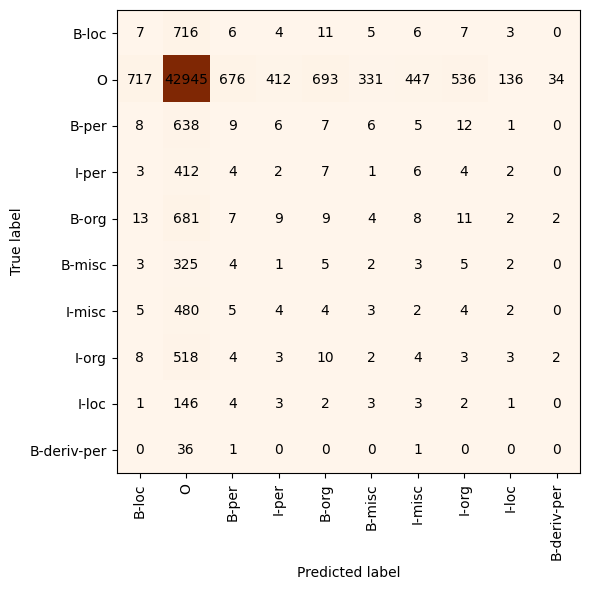

{'B-deriv-per': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, 'B-loc': {'precision': 0.009150326797385621, 'recall': 0.009150326797385621, 'f1-score': 0.009150326797385621, 'support': 765.0}, 'B-misc': {'precision': 0.0056022408963585435, 'recall': 0.005714285714285714, 'f1-score': 0.005657708628005658, 'support': 350.0}, 'B-org': {'precision': 0.012032085561497326, 'recall': 0.012064343163538873, 'f1-score': 0.012048192771084336, 'support': 746.0}, 'B-per': {'precision': 0.0125, 'recall': 0.01300578034682081, 'f1-score': 0.01274787535410765, 'support': 692.0}, 'I-loc': {'precision': 0.006578947368421052, 'recall': 0.006060606060606061, 'f1-score': 0.006309148264984227, 'support': 165.0}, 'I-misc': {'precision': 0.004123711340206186, 'recall': 0.003929273084479371, 'f1-score': 0.004024144869215292, 'support': 509.0}, 'I-org': {'precision': 0.005136986301369863, 'recall': 0.005385996409335727, 'f1-score': 0.0052585451358457495, 'support': 557.0}, 'I-per': {'precis

IndexError: Replacement index 6 out of range for positional args tuple

<Figure size 640x480 with 0 Axes>

In [9]:
# For each model, repeat training and testing 5 times
model_list = ["xlm-r-large"]

for model in model_list:
    for run in list(range(5)):
        current_results_dict = train_and_test(model, train_df, test_df)

        # Add to the dict model name, dataset name and run
        current_results_dict["model"] = model
        current_results_dict["run"] = "{}-{}".format(model, run)
        current_results_dict["dataset"] = dataset_path

        # Add to the file with results all important information
        with open("ner-results.txt", "a") as file:
            file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["label-report"]))

        # Add to the original test_df y_preds
        test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

        # Save entire dict just in case
        with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
            json.dump(current_results_dict, backlog, indent=2)
    
        print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))